In [1]:
# Import necessary libraries
from dataset import Dataset
from feature_extractor import *
from monitors_logits import *
from evaluation import Evaluator
import torch
from models import *
import pandas as pd
import os
import csv

In [2]:
# Set batch size and device
batch_size = 10
device_name = 'cuda:0' if torch.cuda.is_available() else 'cpu'

/home/njemmat/anaconda3/envs/neural-network-monitoring-benchmark/lib/python3.10/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853668/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Define datasets

all_id_datasets = ["cifar10", "svhn", "cifar100"]

all_ood_datasets = [["cifar100", "svhn", "lsun"],
                    ["cifar10", "tiny_imagenet", "lsun"],
                    ["cifar10", "svhn", "lsun"]]


# Define perturbations and attacks
all_perturbations = ["brightness", "blur", "pixelization"]

all_attacks = ["fgsm", "deepfool", "pgd"]


# Define ReAct clip values and monitor temperatures
react_clip = [0.8, 0.9, 0.95, 0.99]
monitor_temperature = [1, 50, 75, 100]

# alpha doctor
alpha = [2, 3, 4, 6]


# Define models and layers
all_models = ["resnet", "densenet"]
all_layers_ids = [[32], [98]]

cv = 5





In [4]:
# Initialize lists to store evaluation metrics
auroc_values_msp = []
auroc_values_DOCTOR = []

aupr_values_msp = []
aupr_values_DOCTOR = []

tnr95tpr_values_msp = []
tnr95tpr_values_DOCTOR = []

In [5]:
# Loop through models
for h in range(len(all_models)):
    model = all_models[h]
    for layer in all_layers_ids[h]:
        for n in range(len(all_id_datasets)):
            id_dataset = all_id_datasets[n]
            for i in range(len(all_ood_datasets[n])):
                ood_dataset = all_ood_datasets[n][i]

                dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
                dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
                dataset_ood = Dataset(ood_dataset, "test", model, None, None, batch_size=batch_size)

                feature_extractor = FeatureExtractor(model, id_dataset, [layer], device_name)
                features_train, logits_train, softmax_train, pred_train, lab_train = feature_extractor.get_features(dataset_train)
                features_test, logits_test, softmax_test, pred_test, lab_test = feature_extractor.get_features(dataset_test)
                features_ood, logits_ood, softmax_ood, pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

                eval_oms = Evaluator("oms", is_novelty=(id_dataset != ood_dataset))
                eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)


                # Moniteur MSP
                monitor = MaxSoftmaxProbabilityMonitor()
                monitor.fit()

                scores_test_maxsoftmax = monitor.predict(softmax_test)
                scores_ood_maxsoftmax = monitor.predict(softmax_ood)

                aupr_msp = eval_oms.get_average_precision(scores_test_maxsoftmax, scores_ood_maxsoftmax)
                auroc_msp = eval_oms.get_auroc(scores_test_maxsoftmax, scores_ood_maxsoftmax)
                tnr95tpr_msp = eval_oms.get_tnr_frac_tpr_oms(scores_test_maxsoftmax, scores_ood_maxsoftmax, frac=0.95)


                # Moniteur DOCTOR alpha
                monitor_doctor_alpha = Doctor(mode="alpha")
                monitor_doctor_alpha.fit()

                scores_test_doctor_alpha = monitor_doctor_alpha.predict(softmax_test)
                scores_ood_doctor_alpha = monitor_doctor_alpha.predict(softmax_ood)

                aupr_doctor_alpha = eval_oms.get_average_precision(scores_test_doctor_alpha, scores_ood_doctor_alpha)
                auroc_doctor_alpha = eval_oms.get_auroc(scores_test_doctor_alpha, scores_ood_doctor_alpha)
                tnr95tpr_doctor_alpha = eval_oms.get_tnr_frac_tpr_oms(scores_test_doctor_alpha, scores_ood_doctor_alpha, frac=0.95)



                auroc_values_msp.append(auroc_msp)
                auroc_values_DOCTOR.append(auroc_doctor_alpha)

                aupr_values_msp.append(aupr_msp)
                aupr_values_DOCTOR.append(aupr_doctor_alpha)


                tnr95tpr_values_msp.append(tnr95tpr_msp)
                tnr95tpr_values_DOCTOR.append(tnr95tpr_doctor_alpha)




            for k in range(len(all_attacks)):
                ood_dataset = id_dataset

                adversarial_attack = all_attacks[k]


                dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
                dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
                dataset_ood = Dataset(id_dataset, "test", model, None, adversarial_attack, batch_size=batch_size)

                feature_extractor = FeatureExtractor(model, id_dataset, [layer], device_name)

                features_train, logits_train, softmax_train, \
                    pred_train, lab_train = feature_extractor.get_features(dataset_train)
                features_test, logits_test, softmax_test, \
                    pred_test, lab_test = feature_extractor.get_features(dataset_test)
                features_ood, logits_ood, softmax_ood, \
                    pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

                eval_oms = Evaluator("oms", is_novelty=(id_dataset != ood_dataset))
                eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)


                # Moniteur MSP
                monitor = MaxSoftmaxProbabilityMonitor()
                monitor.fit()

                scores_test_maxsoftmax = monitor.predict(softmax_test)
                scores_ood_maxsoftmax = monitor.predict(softmax_ood)

                aupr_msp = eval_oms.get_average_precision(scores_test_maxsoftmax, scores_ood_maxsoftmax)
                auroc_msp = eval_oms.get_auroc(scores_test_maxsoftmax, scores_ood_maxsoftmax)
                tnr95tpr_msp = eval_oms.get_tnr_frac_tpr_oms(scores_test_maxsoftmax, scores_ood_maxsoftmax, frac=0.95)


                # Moniteur DOCTOR alpha
                monitor_doctor_alpha = Doctor(mode="alpha")
                monitor_doctor_alpha.fit()

                scores_test_doctor_alpha = monitor_doctor_alpha.predict(softmax_test)
                scores_ood_doctor_alpha = monitor_doctor_alpha.predict(softmax_ood)

                aupr_doctor_alpha = eval_oms.get_average_precision(scores_test_doctor_alpha, scores_ood_doctor_alpha)
                auroc_doctor_alpha = eval_oms.get_auroc(scores_test_doctor_alpha, scores_ood_doctor_alpha)
                tnr95tpr_doctor_alpha = eval_oms.get_tnr_frac_tpr_oms(scores_test_doctor_alpha, scores_ood_doctor_alpha, frac=0.95)


                auroc_values_msp.append(auroc_msp)
                auroc_values_DOCTOR.append(auroc_doctor_alpha)

                aupr_values_msp.append(aupr_msp)
                aupr_values_DOCTOR.append(aupr_doctor_alpha)


                tnr95tpr_values_msp.append(tnr95tpr_msp)
                tnr95tpr_values_DOCTOR.append(tnr95tpr_doctor_alpha)


            for j in range(len(all_perturbations)):
                ood_dataset = id_dataset

                additional_transform = all_perturbations[j]


                dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
                dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
                dataset_ood = Dataset(id_dataset, "test", model, additional_transform, None, batch_size=batch_size)

                feature_extractor = FeatureExtractor(model, id_dataset, [layer], device_name)

                features_train, logits_train, softmax_train, \
                    pred_train, lab_train = feature_extractor.get_features(dataset_train)
                features_test, logits_test, softmax_test, \
                    pred_test, lab_test = feature_extractor.get_features(dataset_test)
                features_ood, logits_ood, softmax_ood, \
                    pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

                eval_oms = Evaluator("oms", is_novelty=(id_dataset != ood_dataset))
                eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)


                # Moniteur MSP
                monitor = MaxSoftmaxProbabilityMonitor()
                monitor.fit()

                scores_test_maxsoftmax = monitor.predict(softmax_test)
                scores_ood_maxsoftmax = monitor.predict(softmax_ood)

                aupr_msp = eval_oms.get_average_precision(scores_test_maxsoftmax, scores_ood_maxsoftmax)
                auroc_msp = eval_oms.get_auroc(scores_test_maxsoftmax, scores_ood_maxsoftmax)
                tnr95tpr_msp = eval_oms.get_tnr_frac_tpr_oms(scores_test_maxsoftmax, scores_ood_maxsoftmax, frac=0.95)


                # Moniteur DOCTOR alpha
                monitor_doctor_alpha = Doctor(mode="alpha")
                monitor_doctor_alpha.fit()

                scores_test_doctor_alpha = monitor_doctor_alpha.predict(softmax_test)
                scores_ood_doctor_alpha = monitor_doctor_alpha.predict(softmax_ood)

                aupr_doctor_alpha = eval_oms.get_average_precision(scores_test_doctor_alpha, scores_ood_doctor_alpha)
                auroc_doctor_alpha = eval_oms.get_auroc(scores_test_doctor_alpha, scores_ood_doctor_alpha)
                tnr95tpr_doctor_alpha = eval_oms.get_tnr_frac_tpr_oms(scores_test_doctor_alpha, scores_ood_doctor_alpha, frac=0.95)



                auroc_values_msp.append(auroc_msp)
                auroc_values_DOCTOR.append(auroc_doctor_alpha)

                aupr_values_msp.append(aupr_msp)
                aupr_values_DOCTOR.append(aupr_doctor_alpha)


                tnr95tpr_values_msp.append(tnr95tpr_msp)
                tnr95tpr_values_DOCTOR.append(tnr95tpr_doctor_alpha)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./Data/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and v

In [6]:
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
metrics_compare_colname = ['AUROC', 'AUPR', 'TNR95TPR']

# Initialize arrays for statistical results
res_statistic = np.zeros((1, len(metrics_compare_colname)))
res_pvalue = np.zeros((1, len(metrics_compare_colname)))
flag =  np.zeros((1, len(metrics_compare_colname))) 

p_value_list = []

In [8]:
from _plotting import _bron_kerbosch, _find_maximal_cliques, sign_plot, sign_table, sign_array
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from _plotting import *

In [9]:
# Function to compute average ranks
def compute_average_ranks(list1, list2, pct=True):
    df = (pd.DataFrame({'list1':list1, 'list2':list2})
          .rename_axis('cv_fold')
          .melt(
              var_name='estimator',
              value_name='score',
              ignore_index=False,
          )
          .reset_index())
    
    avg_rank = df.groupby('cv_fold').score.rank(pct=pct).groupby(df.estimator).mean()

    return avg_rank[0], avg_rank[1]

In [10]:
# Set the significance level
alpha = 0.05


wilcoxon_statistic_auroc, wilcoxon_pvalue_auroc = wilcoxon(auroc_values_msp, auroc_values_DOCTOR, alternative='two-sided')
wilcoxon_statistic_aupr, wilcoxon_pvalue_aupr = wilcoxon(aupr_values_msp, aupr_values_DOCTOR, alternative='two-sided')
wilcoxon_statistic_tnr95tpr, wilcoxon_pvalue_tnr95tpr = wilcoxon(tnr95tpr_values_msp, tnr95tpr_values_DOCTOR, alternative='two-sided')


# Wilcoxon Test and analysis for AUROC

flag_auroc = np.zeros((1, 1))
if wilcoxon_pvalue_auroc <= alpha:
    avg_rank_groupA_auroc, avg_rank_groupB_auroc = compute_average_ranks(auroc_values_DOCTOR, auroc_values_msp)

    if avg_rank_groupA_auroc > avg_rank_groupB_auroc:
        best_monitor = "DOCTOR"
        flag_auroc[0, 0] = 1
    else:
        best_monitor = "MSP"
        flag_auroc[0, 0] = -1
else:
    best_monitor = "Equal"

    
print(f"Wilcoxon Test Results:")
print(f"Statistic: {wilcoxon_statistic_auroc}")
print(f"P-value: {wilcoxon_pvalue_auroc}")
if wilcoxon_pvalue_auroc <= alpha:
    print("Reject the null hypothesis. The distributions are different.")
else:
    print("Fail to reject the null hypothesis. The distributions are not significantly different.")
print(f"Best Monitor based on AUROC: {best_monitor}")


# Wilcoxon Test and analysis for AUPR

flag_aupr = np.zeros((1, 1))

if wilcoxon_pvalue_aupr <= alpha:
    avg_rank_groupA_aupr, avg_rank_groupB_aupr = compute_average_ranks(aupr_values_DOCTOR, aupr_values_msp)

    if avg_rank_groupA_aupr > avg_rank_groupB_aupr:
        best_monitor_aupr = "DOCTOR"
        flag_aupr[0, 0] = 1
    else:
        best_monitor_aupr = "MSP"
        flag_aupr[0, 0] = -1
else:
    best_monitor_aupr = "Equal"
    
    
    
print(f"Wilcoxon Test Results AUPR:")
print(f"Statistic: {wilcoxon_statistic_aupr}")
print(f"P-value: {wilcoxon_pvalue_aupr}")
if wilcoxon_pvalue_aupr <= alpha:
    print("Reject the null hypothesis. The distributions are different.")
else:
    print("Fail to reject the null hypothesis. The distributions are not significantly different.")
print(f"Best Monitor based on AUPR: {best_monitor}")

# Wilcoxon Test and analysis for TNR95TPR
flag_tnr95tpr = np.zeros((1, 1))

if wilcoxon_pvalue_tnr95tpr <= alpha:
    avg_rank_groupA_tnr95tpr, avg_rank_groupB_tnr95tpr = compute_average_ranks(tnr95tpr_values_DOCTOR, tnr95tpr_values_msp)

    if avg_rank_groupA_tnr95tpr > avg_rank_groupB_tnr95tpr:
        best_monitor_tnr95tpr = "DOCTOR" 
        flag_tnr95tpr[0, 0] = 1
    else:
        best_monitor_tnr95tpr = "MSP"
        flag_tnr95tpr[0, 0] = -1
else:
    best_monitor_tnr95tpr = "Equal"

print(f"Wilcoxon Test Results TNR95TPR:")
print(f"Statistic: {wilcoxon_statistic_tnr95tpr}")
print(f"P-value: {wilcoxon_pvalue_tnr95tpr}")
if wilcoxon_pvalue_aupr <= alpha:
    print("Reject the null hypothesis. The distributions are different.")
else:
    print("Fail to reject the null hypothesis. The distributions are not significantly different.")
print(f"Best Monitor based on TNR95TPR: {best_monitor}")


Wilcoxon Test Results:
Statistic: 61.0
P-value: 4.4144626206066466e-09
Reject the null hypothesis. The distributions are different.
Best Monitor based on AUROC: DOCTOR
Wilcoxon Test Results AUPR:
Statistic: 78.0
P-value: 1.055939619980661e-08
Reject the null hypothesis. The distributions are different.
Best Monitor based on AUPR: DOCTOR
Wilcoxon Test Results TNR95TPR:
Statistic: 14.0
P-value: 0.0006806104529480628
Reject the null hypothesis. The distributions are different.
Best Monitor based on TNR95TPR: DOCTOR


In [11]:
labels = ['AUROC', 'AUPR', 'TNR95TPR']
wilcoxon_pvalues = [wilcoxon_pvalue_auroc, wilcoxon_pvalue_aupr, wilcoxon_pvalue_tnr95tpr]
flag_values = [flag_auroc[0, 0], flag_aupr[0, 0], flag_tnr95tpr[0, 0]]

res_pvalue = np.array([wilcoxon_pvalues])
flag = np.array([flag_values])

/home/njemmat/anaconda3/envs/neural-network-monitoring-benchmark/lib/python3.10/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/njemmat/anaconda3/envs/neural-network-monitoring-benchmark/lib/python3.10/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/tmp/ipykernel_29947/2851755372.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


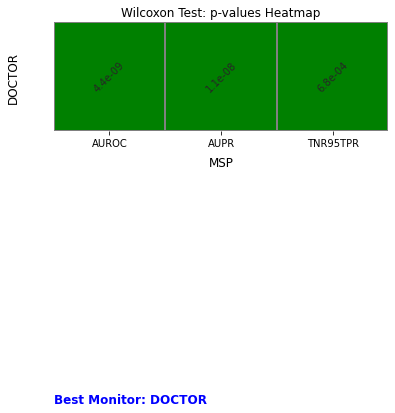

In [12]:
fig, ax = plt.subplots(figsize=(6, 2))
ax_plot = sns.heatmap(res_pvalue, annot=True, fmt='.1e', cbar=False, annot_kws={'rotation': 45}, 
                      xticklabels=labels, yticklabels=[],
                      cmap=ListedColormap(['white']), ax=ax)
ax_plot = sns.heatmap(res_pvalue, mask=(flag!=1), cbar=False, 
                      xticklabels=labels, yticklabels=[], cmap=ListedColormap(['green']), ax=ax)

ax_plot = sns.heatmap(res_pvalue, mask=(flag!=-1), cbar=False, linewidths=2, linecolor='gray',
                      xticklabels=labels, yticklabels=[], cmap=ListedColormap(['sandybrown']), ax=ax) 

best_monitor = "DOCTOR" if flag_values[1] == 1 else "MSP"
ax.text(0, 3.5, f'Best Monitor: {best_monitor}', fontsize=12, color='blue', fontweight='bold')

ax.annotate('MSP', xy=(0.5, -0.25), xytext=(0.5, -0.35),  # Ajustez les valeurs xytext pour réduire la distance
            xycoords='axes fraction', textcoords='axes fraction', 
            fontsize=12,
            horizontalalignment='center', verticalalignment='bottom')
            
ax.annotate('DOCTOR', xy=(-0.1, 0.5), xytext=(-0.1, 0.5),  # Ajustez les valeurs xytext pour réduire la distance
            xycoords='axes fraction', textcoords='axes fraction', 
            fontsize=12,
            horizontalalignment='right', verticalalignment='center', rotation=90)


ax.set_title('Wilcoxon Test: p-values Heatmap')
plt.tight_layout()

plt.show()